In [1]:
import warnings
import dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from paeio import io

import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
dotenv.load_dotenv()

True

In [2]:
df = io.read_csv('https://testmlopaes.dfs.core.windows.net/testing/input/heart.csv')
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [14]:
df.cp.unique()

array([3, 2, 1, 0], dtype=int64)

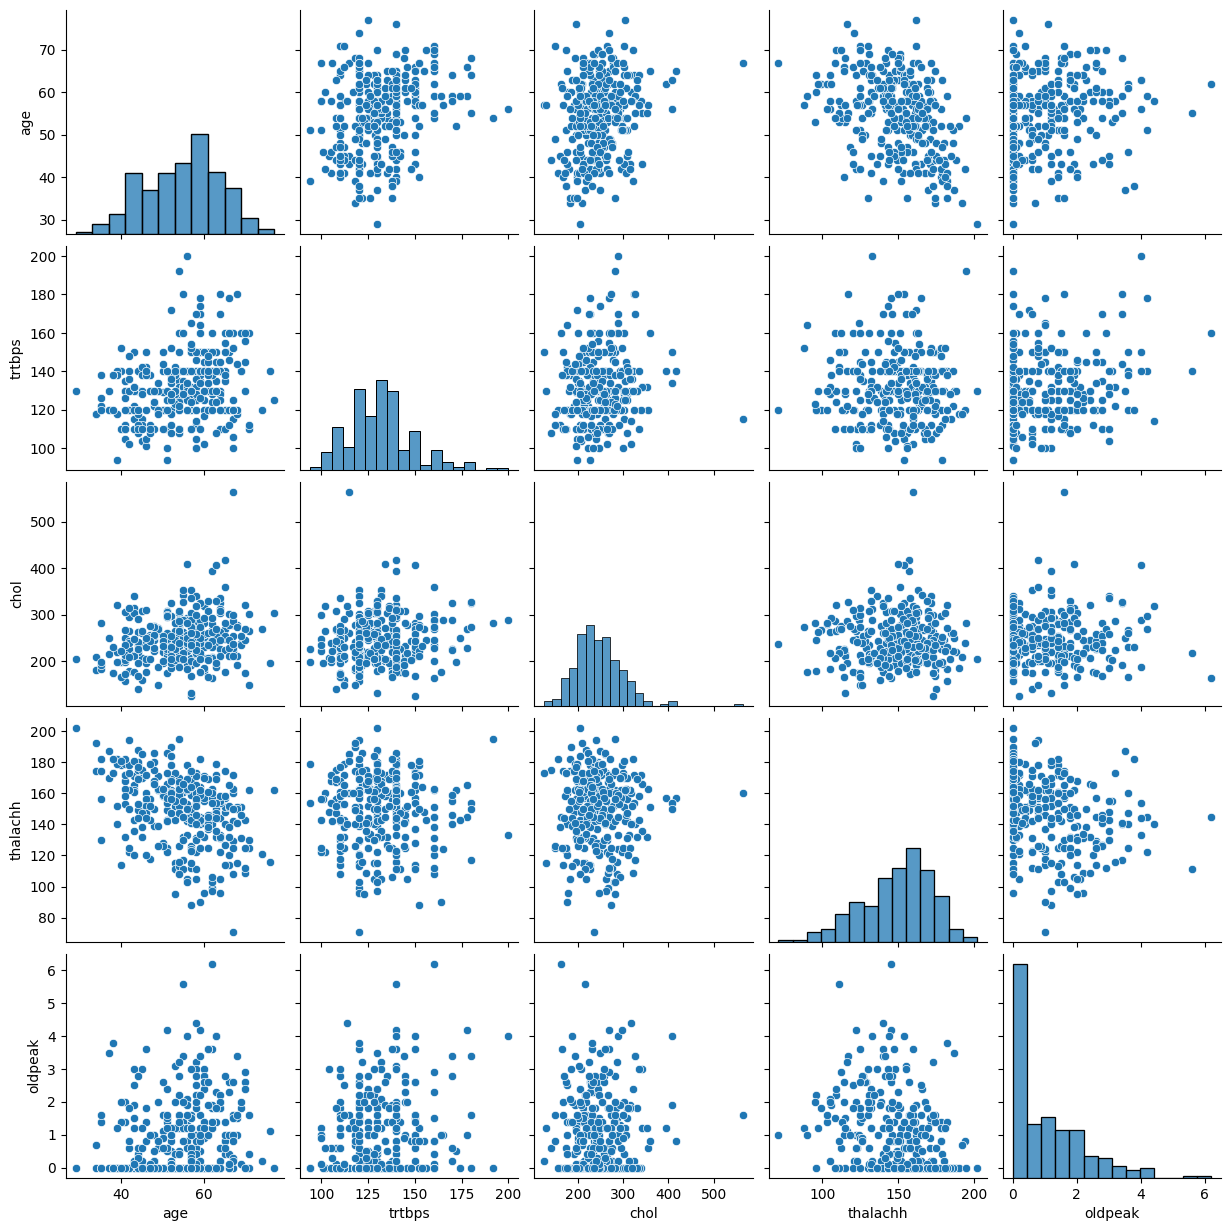

In [3]:
sns.pairplot(df[['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']]);

In [4]:
X = df.drop(columns=['output'])
y = df['output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
model = RandomForestClassifier(n_estimators=10, n_jobs=-1).fit(X_train, y_train)

param_grid = {
    'n_estimators': [80, 100, 120],
    'max_depth': [3, 5, 7],
}
grid = GridSearchCV(model, param_grid, n_jobs=-1).fit(X_train, y_train)
grid.best_params_

{'max_depth': 7, 'n_estimators': 120}

In [6]:
grid_model = RandomForestClassifier(
    n_estimators=grid.best_params_['n_estimators'],
    max_depth=grid.best_params_['max_depth'],
    n_jobs=-1,
).fit(X_train, y_train)

In [7]:
def evalBinaryClassifier(model, x, y, labels=['Positives','Negatives']):
    '''
    Visualize the performance of  a Logistic Regression Binary Classifier.
    
    Displays a labelled Confusion Matrix, distributions of the predicted
    probabilities for both classes, the ROC curve, and F1 score of a fitted
    Binary Logistic Classifier. Author: gregcondit.com/articles/logr-charts
    
    Parameters
    ----------
    model : fitted scikit-learn model with predict_proba & predict methods
        and classes_ attribute. Typically LogisticRegression or 
        LogisticRegressionCV
    
    x : {array-like, sparse matrix}, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples
        in the data to be tested, and n_features is the number of features
    
    y : array-like, shape (n_samples,)
        Target vector relative to x.
    
    labels: list, optional
        list of text labels for the two classes, with the positive label first
        
    Displays
    ----------
    3 Subplots
    
    Returns
    ----------
    F1: float
    '''
    #model predicts probabilities of positive class
    p = model.predict_proba(x)
    if len(model.classes_)!=2:
        raise ValueError('A binary class problem is required')
    if model.classes_[1] == 1:
        pos_p = p[:,1]
    elif model.classes_[0] == 1:
        pos_p = p[:,0]
    
    #FIGURE
    plt.figure(figsize=[12,5])
    
    #1 -- Confusion matrix
    cm = confusion_matrix(y,model.predict(x))
    plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                annot_kws={"size": 14}, fmt='g')
    cmlabels = ['True Negatives', 'False Positives',
              'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Matriz de Confusão', size=15)
    plt.xlabel('Predição', size=13)
    plt.ylabel('Realidade', size=13)
      
    #2 -- Distributions of Predicted Probabilities of both classes
    df = pd.DataFrame({'probPos':pos_p, 'target': y})
    plt.subplot(132)
    plt.hist(df[df.target==1].probPos, density=True, bins=25,
             alpha=.5, color='green',  label=labels[0])
    plt.hist(df[df.target==0].probPos, density=True, bins=25,
             alpha=.5, color='red', label=labels[1])
    plt.axvline(.5, color='blue', linestyle='--', label='Limiar(50%)')
    plt.xlim([0,1])
    plt.title('Distribuição das Predições', size=15)
    plt.xlabel('Probabilidade (predição)', size=13)
    plt.ylabel('Amostras', size=13)
    plt.legend(loc="upper right")
    
    #3 -- ROC curve with annotated decision point
    fp_rates, tp_rates, _ = roc_curve(y,p[:,1])
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color='green',
             lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    #plot current decision point:
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.tight_layout()
    plt.show()
    #Print and Return the F1 score
    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)

    print(
        f'Precision: {round(precision, 2)} | '
        f'Recall: {round(recall, 2)} | '
        f'F1 Score: {round(F1, 2)} | '
        f'AUC Score: {round(roc_auc, 2)} | ')
    return F1

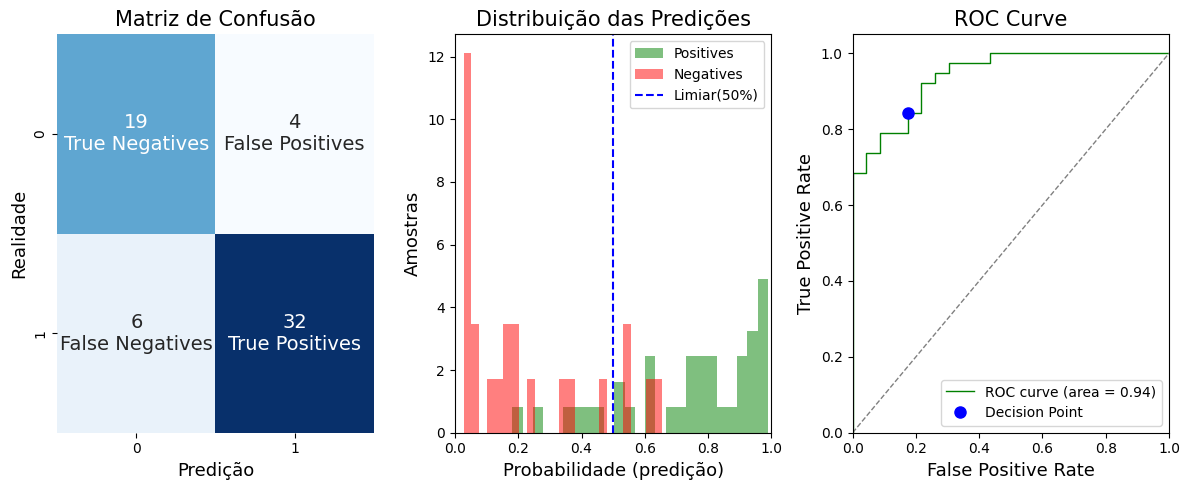

Precision: 0.89 | Recall: 0.84 | F1 Score: 0.86 | AUC Score: 0.94 | 


0.8648648648648649

In [8]:
evalBinaryClassifier(grid_model, X_test, y_test)

In [9]:
grid_model.feature_names_in_

array(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall'], dtype=object)

In [39]:
grid_model.feature_importances_

array([0.08303544, 0.03328514, 0.12186901, 0.07431458, 0.06603321,
       0.00980216, 0.01971982, 0.13240453, 0.04436491, 0.13496264,
       0.04272673, 0.13158383, 0.10589801])

In [30]:
impt_index = grid_model.feature_importances_ > 0.03
impt_index

array([ True,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True,  True])

In [31]:
X_train_new = X_train[X_train.columns[impt_index]]
X_test_new = X_test[X_test.columns[impt_index]]

In [32]:
model_new = RandomForestClassifier(n_estimators=10, n_jobs=-1).fit(X_train_new, y_train)

param_grid = {
    'n_estimators': [80, 100, 120],
    'max_depth': [3, 5, 7],
}
grid_new = GridSearchCV(model_new, param_grid, n_jobs=-1).fit(X_train_new, y_train)
grid_new.best_params_

{'max_depth': 3, 'n_estimators': 100}

In [33]:
grid_model_new = RandomForestClassifier(
    n_estimators=grid_new.best_params_['n_estimators'],
    max_depth=grid_new.best_params_['max_depth'],
    n_jobs=-1,
).fit(X_train_new, y_train)

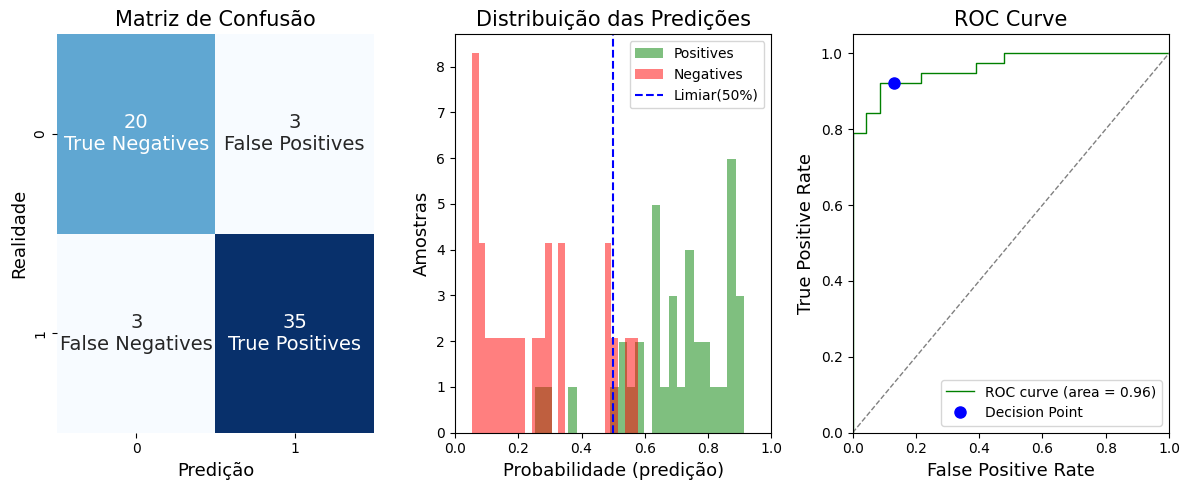

Precision: 0.92 | Recall: 0.92 | F1 Score: 0.92 | AUC Score: 0.96 | 


0.9210526315789473

In [34]:
evalBinaryClassifier(grid_model_new, X_test_new, y_test)

In [37]:
grid_model_new.feature_importances_

array([0.04754565, 0.01962595, 0.2124357 , 0.0358982 , 0.02691549,
       0.14098772, 0.07679948, 0.11661044, 0.03683801, 0.16690477,
       0.11943859])

In [35]:
grid_model_new.feature_names_in_

array(['age', 'sex', 'cp', 'trtbps', 'chol', 'thalachh', 'exng',
       'oldpeak', 'slp', 'caa', 'thall'], dtype=object)

In [27]:
import pickle

In [36]:
pickle.dump(grid_model_new, open('heart_model.pkl', "wb"))

In [53]:
grid_model_new.predict_proba(X_test_new.head(1))[:,1].round(4)

array([0.9133])